<a href="https://colab.research.google.com/github/PRIMEADAWAS/CEB_Assignment/blob/main/RADI623_A1_PasitSupholkhan_(Assignment_NLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RADI623_A1_PasitSupholkhan (Assignment: NLP)

# Assignment: NLP

The problem of predicting one’s illnesses wrongly through self-diagnosis in medicine is very real. In a report by the Telegraph (See Link 1: One in for self), nearly one in four self-diagnose instead of visiting the doctor. Out of those who misdiagnose, nearly half have misdiagnosed their illness wrongly reported (See in link 2: Cyberchondria). While there could be multiple root causes to this problem, this could stem from a general unwillingness and inability to seek professional help.  


11% of the respondents surveyed, for example, could not find an appointment in time. This means that crucial time is lost during the screening phase of a medical treatment, and early diagnosis which could have resulted in illnesses treated earlier was not achieved.

- (10 Points) Conduct an exploratory data analysis on the dataset.  Report the corpus statistics with appropriate visualization.  Explain clearly why the selected visualization fits your purpose.  
(10 Points) Draw a block diagram to illustrate an overview of your experiment.  Each block represents a task required in a deep learning experiment such as vectorization, data splitting, etc.
(10 Points) Uses BERT without fine tuning on the LSTM with 50 neurons for the baseline model.  Other hyperparameters are not controlled.   
(10 Points) Report the baseline results with appropriate metrics obtained from the baseline model
(10 Points) Criticize the results from the baseline model based on theoretical and practical perspective with supporting literature
(10 Points) Propose the better model with supporting assumptions why your proposed model should be better than the baseline model.  Clearly explanations are required in which aspect that you would like to improve from the baseline model: for example, prediction performance, runtime, … etc. and why such aspects should be concerned in this problem.
(10 Points) Conduct an experiment on your proposed model
(10 Points) Report the results obtained from your proposed model with appropriate metrics
(10 Points) Criticize the results from the proposed model based on theoretical and practical perspective with supporting literature

## Download & install Library


In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
# import tensorflow as tf
import torch

In [ ]:
!pip install transformers
# !pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 106.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.6 MB/s eta 0:00:00


In [ ]:
import os
import time
import logging
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import transformers
from transformers import AutoTokenizer, BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

In [ ]:
def set_seed(seed):
    """ Set all seeds to make results reproducible (deterministic mode).
        When seed is a false-y value or not supplied, disables deterministic mode. """
    if seed:
        logging.info(f"Running in deterministic mode with seed {seed}")
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
    else:
        logging.info(f"Running in non-deterministic mode")
      
set_seed(6536115)

check GPU avialability 

In [ ]:
# =============================================================================
# ## check GPU
# =============================================================================
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


# Download Dataset


In [ ]:
url = r'https://raw.githubusercontent.com/PRIMEADAWAS/Python101/main/Pytorch101/mtsamples.csv'

In [ ]:
# import dataset
df = pd.read_csv(url)[['transcription', 'medical_specialty']]
df['medical_specialty'] = df['medical_specialty'].str.strip()

# labelencoder = LabelEncoder()
# df['label'] = labelencoder.fit_transform(df['medical_specialty'])

# Display 10 random rows from the data.
df.sample(10)

,transcription,medical_specialty
1130,"PREOPERATIVE DIAGNOSIS: , Persistent pneumonia...",Surgery
1388,"SUBJECTIVE: , The patient was seen and examine...",SOAP / Chart / Progress Notes
3954,"PRIMARY DISCHARGE DIAGNOSES:,1. Urinary tract...",Discharge Summary
2250,"PREOPERATIVE DIAGNOSIS:, Torn rotator cuff, r...",Orthopedic
1095,"HISTORY: , The patient is an 86-year-old woman...",Surgery
4716,"PROCEDURE PERFORMED: ,DDDR permanent pacemake...",Cardiovascular / Pulmonary
1937,"CHIEF COMPLAINT:, A 2-month-old female with 1...",Pediatrics - Neonatal
2597,"PREOPERATIVE DIAGNOSIS: , Endometrial cancer.,...",Obstetrics / Gynecology
2078,"HISTORY OF PRESENT ILLNESS: , The patient is a...",Orthopedic
2414,"RE: Sample Patient,Dear Dr. Sample:,Sample Pa...",Ophthalmology


# Preprocessing 

find null value

In [ ]:
df.isnull().sum()

transcription        33
medical_specialty     0
dtype: int64

remove null values

In [ ]:
df = df.dropna().reset_index(drop=True)

In [ ]:
def showClass():
  print('Total classes : ',df['medical_specialty'].nunique())
  plt.figure(figsize=(8,8))
  sns.countplot(y='medical_specialty', 
                data = df, 
                order = df['medical_specialty'].value_counts().index)
  plt.show()

Total classes :  40


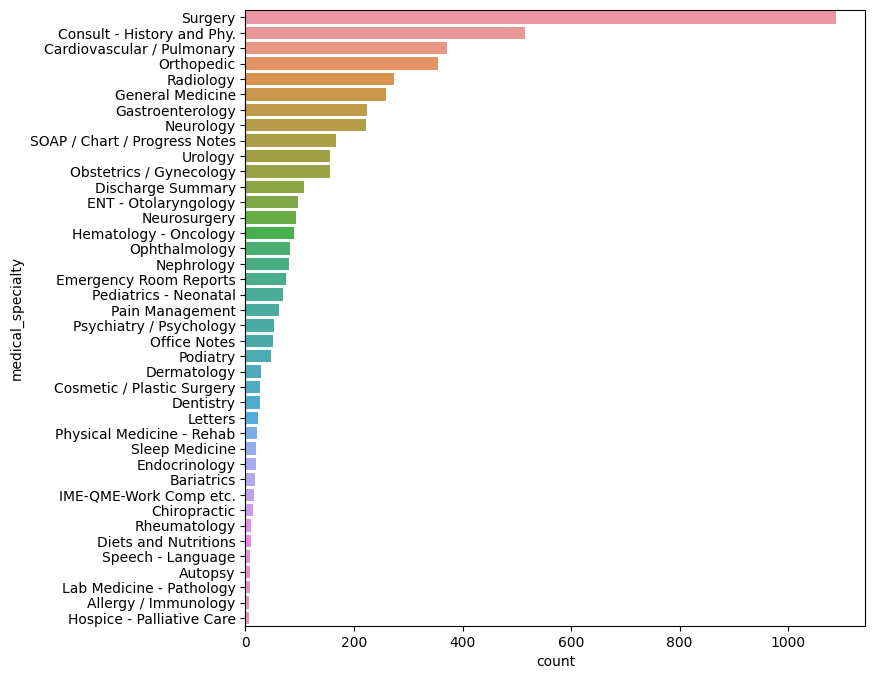

In [ ]:
showClass()

remove row that contain not enough information

In [ ]:
for i in range(4966):
    if len(df['transcription'][i]) < 40:
        print(df['transcription'][i])

CHIEF COMPLAINT:,
INDICATION:  ,
SUBJECTIVE:,
INDICATIONS:,
OPERATION:,
OPERATION:,
CHIEF COMPLAINT:  ,
REASON FOR EVALUATION:,
CHIEF COMPLAINT:,
CHIEF COMPLAINT:  ,
CHIEF COMPLAINT:,
SUBJECTIVE:,
INDICATION:  ,
CHIEF COMPLAINT:,
REASON FOR EVALUATION:,
INDICATIONS:,


In [ ]:
df = df[df['transcription'].str.len() > 40]

remove duplicate row

In [ ]:
# duplicate transcription with difference medical specialty
df['transcription'].nunique()

2349

In [ ]:
df = df.sort_values(['transcription','medical_specialty'], ascending=True).drop_duplicates('transcription').sort_index()
df

,transcription,medical_specialty
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",Bariatrics
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",Bariatrics
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary
...,...,...
4961,"HISTORY:, I had the pleasure of meeting and e...",Allergy / Immunology
4962,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...",Allergy / Immunology
4963,"SUBJECTIVE: , This is a 42-year-old white fema...",Allergy / Immunology
4964,"CHIEF COMPLAINT: , This 5-year-old male presen...",Allergy / Immunology


In [ ]:
df['medical_specialty'].value_counts()

Consult - History and Phy.       443
Cardiovascular / Pulmonary       369
Orthopedic                       216
Gastroenterology                 171
Neurology                        139
Surgery                          138
Obstetrics / Gynecology          121
Discharge Summary                 90
ENT - Otolaryngology              70
Neurosurgery                      66
Ophthalmology                     63
Hematology - Oncology             51
General Medicine                  51
Pain Management                   49
Nephrology                        47
Emergency Room Reports            30
Dentistry                         24
Cosmetic / Plastic Surgery        23
SOAP / Chart / Progress Notes     22
Dermatology                       21
Podiatry                          18
Bariatrics                        18
Letters                           16
Radiology                         15
Chiropractic                      13
Endocrinology                     12
Psychiatry / Psychology           11
A

In [ ]:
def groupClass(subClass, mainClass):
  df.loc[df.medical_specialty == subClass, "medical_specialty"] = mainClass

Move minor subclass(IME-QME-Work Comp etc., Rheumatology, Physical Medicine - Rehab) in to main class(Office Notes, General Medicine) because its contain low number

In [ ]:
for cls in ['IME-QME-Work Comp etc.']:
  groupClass(cls, 'Office Notes')
for cls in ['Rheumatology' , 'Physical Medicine - Rehab']:
  groupClass(cls, 'General Medicine')

## Class distribution 


Total classes :  34


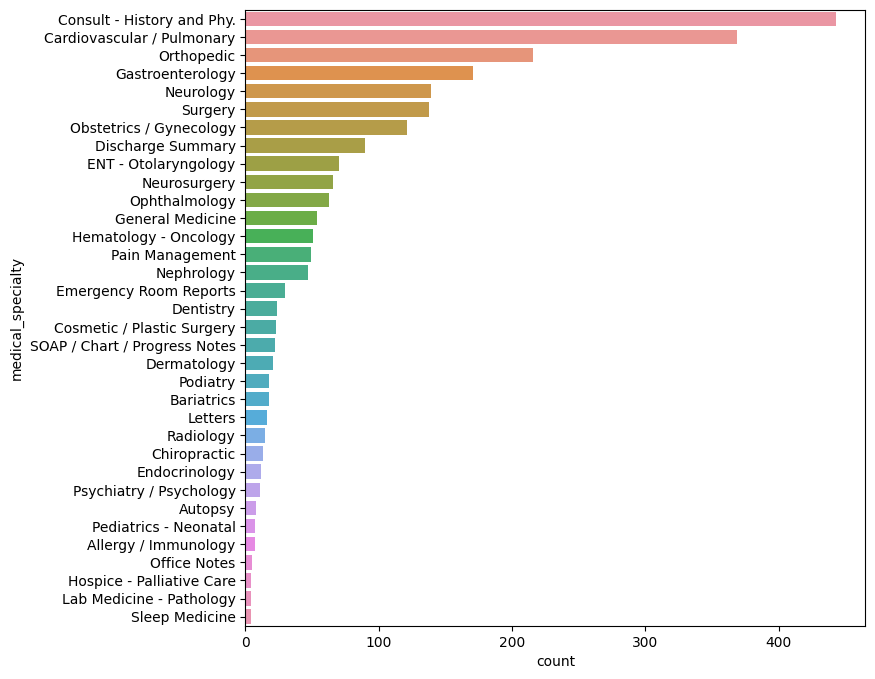

In [ ]:
showClass()

LabelEncoder to coding medical_specialty classes number

In [ ]:
labelencoder = LabelEncoder()
df['label'] = labelencoder.fit_transform(df['medical_specialty'])
df

,transcription,medical_specialty,label
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology,0
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",Bariatrics,2
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",Bariatrics,2
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary,3
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary,3
...,...,...,...
4961,"HISTORY:, I had the pleasure of meeting and e...",Allergy / Immunology,0
4962,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...",Allergy / Immunology,0
4963,"SUBJECTIVE: , This is a 42-year-old white fema...",Allergy / Immunology,0
4964,"CHIEF COMPLAINT: , This 5-year-old male presen...",Allergy / Immunology,0




Let's extract the sentences and labels of our training set as numpy ndarrays.

In [ ]:
# Get the lists of sentences and their labels.
sentences = df.transcription.values
labels = df.label.values

In [ ]:
sentences[0], labels[0]

('SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was seen.  TMs were clear.,Neck:  Supple without adenopathy.

# Visualization

preprocess and clean text

In [ ]:
import re
from tqdm import tqdm

def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - removes punctuation
        - removes any single character tokens ?
    Parameters
    ----------
        message : The text message to be preprocessed
    Returns
    -------
        text: The preprocessed text
    """ 
    # Lowercase the twit message
    text = message.lower()
    # Replace everything not a letter or apostrophe with a space
    text = re.sub('[^a-zA-Z0-9/\']', ' ', text)
    # Remove single letter words
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    
    return text
        
# Process for all messages
preprocessed = [preprocess(message) for message in tqdm(sentences)]



100%|██████████| 2349/2349 [00:00<00:00, 6623.45it/s]


## Tokenize and remove stop word

In [ ]:
from collections import Counter
import logging as logger
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def tokenize_text(text, option):
  '''
  Tokenize the input text as per specified option
    1: Use python split() function
    2: Use regex to extract alphabets plus 's and 't
    3: Use NLTK word_tokenize()
    4: Use NLTK word_tokenize(), remove stop words and apply lemmatization
  '''
  if option == 1:
    return text.split()
  elif option == 2:
    return re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
  elif option == 3:
    return [word for word in word_tokenize(text) if (word.isalpha()==1)]
  elif option == 4:
    words = [word for word in word_tokenize(text) if (word.isalpha()==1)]
    # Remove stop words
    stop = set(stopwords.words('english'))
    words = [word for word in words if (word not in stop)]
    # Lemmatize words (first noun, then verb)
    wnl = nltk.stem.WordNetLemmatizer()
    lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
    return lemmatized
  else:
    logger.warn("Please specify option value between 1 and 4")
    return []

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Corpus and Vocab
count word frequency and evaluate vocabulary size


Tokenizaing: 100%|██████████| 2349/2349 [00:02<00:00, 829.68it/s]


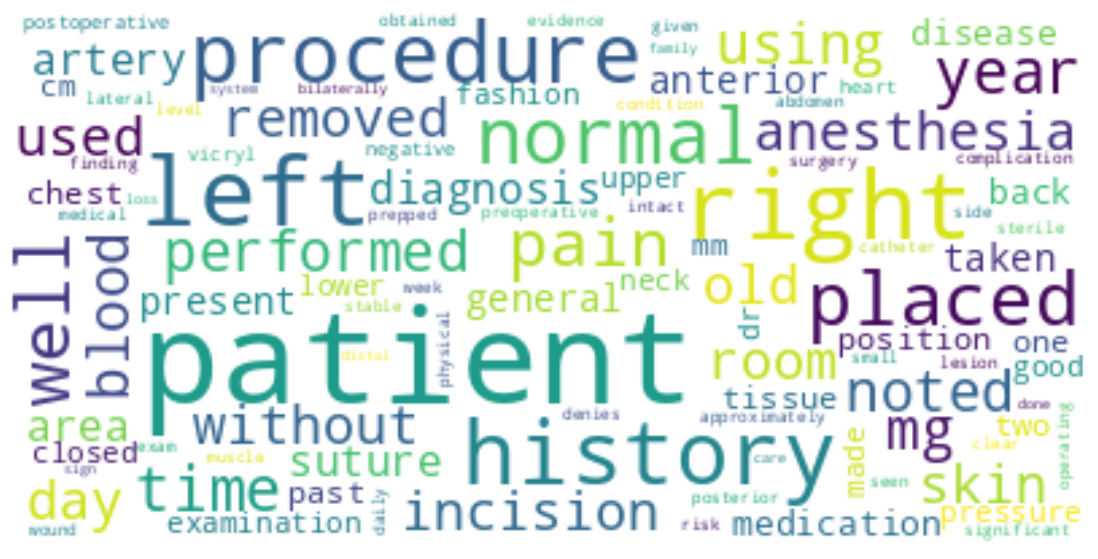

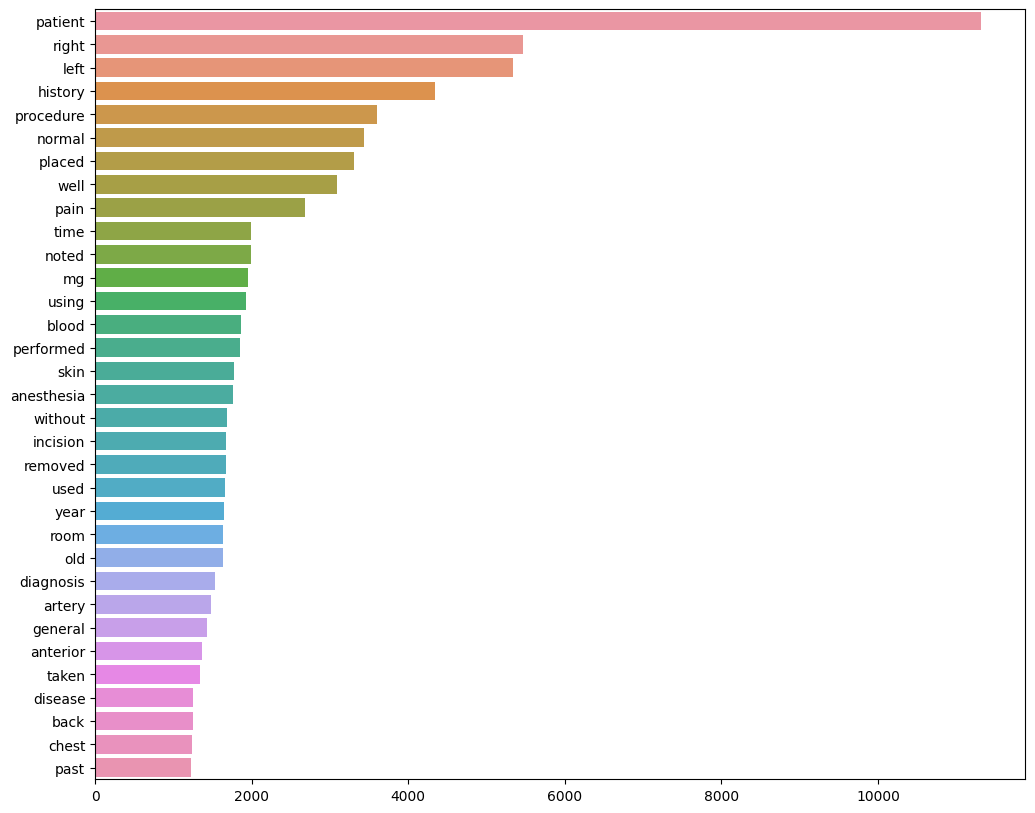

In [ ]:
# Create vocab
import seaborn as sns
def create_vocab(messages, show_graph=False):
    corpus = []
    for message in tqdm(messages, desc="Tokenizaing"):
        tokens = tokenize_text(message, 3) # Use option 3
        corpus.extend(tokens)
    logger.info("The number of all words: {}".format(len(corpus)))

    # Create Counter
    counts = Counter(corpus)
    logger.info("The number of unique words: {}".format(len(counts)))

    # Create BoW
    bow = sorted(counts, key=counts.get, reverse=True)
    logger.info("Top 40 frequent words: {}".format(bow[:40]))

    # Indexing vocabrary, starting from 1.
    vocab = {word: ii for ii, word in enumerate(counts, 1)}
    id2vocab = {v: k for k, v in vocab.items()}

    if show_graph:
        from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
        # Generate Word Cloud image
        text = " ".join(corpus)
        stopwords = set(STOPWORDS)
        stopwords.update(["will", "report", "reporting", "market", "stock", "share"])

        wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white", collocations=False).generate(text)
        plt.figure(figsize=(15,7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

        # Show most frequent words in a bar graph
        most = counts.most_common()[:80]
        x, y = [], []
        for word, count in most:
            if word not in stopwords:
                x.append(word)
                y.append(count)
        plt.figure(figsize=(12,10))
        sns.barplot(x=y, y=x)
        plt.show()

    return vocab

vocab= create_vocab(preprocessed, True)

# BERTbase + LSTM model  
Uses BERT without fine tuning on the LSTM with 50 neurons for the baseline model

## BERT Tokenizer


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [ ]:
!pip install tokenizers

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was seen.  TMs were clear.,Neck:  Supple without a

### Special Tokens



**`[SEP]`**

To determine the end of the sentence

**`[CLS]`**

For classification tasks, 
the special `[CLS]` token must be added to the beginning of every sentence.

BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output (but with the feature values changed, of course!).

![Illustration of CLS token purpose](http://www.mccormickml.com/assets/BERT/CLS_token_500x606.png)

On the output of the final (12th) transformer, *only the first embedding (corresponding to the [CLS] token) is used by the classifier*.


### Sentence Length & Attention Mask



BERT has two constraints:
1. All sentences must be padded or truncated to a fixed length.
2. The maximum sentence length is 512 tokens include **`[CLS]`** and **`[SEP]`**.

Padding add special `[PAD]` token to fill max length, which is at index 0 in the BERT vocabulary.

<img src="http://www.mccormickml.com/assets/BERT/padding_and_mask.png" width="600">

The "Attention Mask" is simply an array of 1s and 0s indicating which tokens are padding and which aren't (seems kind of redundant, doesn't it?!). This mask tells the "Self-Attention" mechanism in BERT not to incorporate these PAD tokens into its interpretation of the sentence.







In [ ]:
# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
    if(max_len >= 512)
      break

print('Max sentence length: ', max_len)

Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


## Training & Validation Split


Divide up our training set to use 80% for train and 20% for test.

In [ ]:
# import tqdm for show progression
from tqdm import tqdm
tqdm.pandas()

In [ ]:
def bertTokenizerEncodePlus(sentences, labels):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for index, sentence in tqdm(enumerate(sentences)):
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sentence, # Sentence to encode.
                          truncation=True, # Cut word length to maximum 512
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 512, # Pad & truncate all sentences.
                          padding='max_length',
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt' # Return pytorch tensors.
                    )
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Print sentence 0, now as a list of IDs.
  # print('Original: ', sentences[0])
  # print('Token IDs:', input_ids[0])

  return input_ids, attention_masks, labels

In [ ]:
from sklearn.model_selection import train_test_split

sentences = np.array(sentences)
# labels = Y.values

train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size = 0.2, stratify = labels, random_state = 6536115)
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences, train_labels, test_size = 0.25, stratify = train_labels, random_state = 6536115)
print(train_sentences.shape, val_sentences.shape, test_sentences.shape)

train_input_ids, train_attention_masks, train_labels = bertTokenizerEncodePlus(train_sentences, train_labels)
val_input_ids, val_attention_masks, val_labels = bertTokenizerEncodePlus(val_sentences, val_labels)
test_input_ids, test_attention_masks, test_labels = bertTokenizerEncodePlus(test_sentences, test_labels)

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

(1413,) (472,) (472,)


1413it [00:28, 48.85it/s]
472it [00:09, 50.91it/s]
472it [00:09, 48.05it/s]


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## Train Base Classification Model

### BertModel

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, by input our dataset and get contexualize wordembedding without fine tuning then pass through LSTM with 50 neurons for the baseline model classification

In [ ]:
# Load pre-trained model (weights)
model_wordembedding = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model_wordembedding.to(device)
# model_wordembedding.cuda()
model_wordembedding.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model_wordembedding.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 199 different named parameters.

==== Embedding Layer ====

embeddings.word_embeddings.weight                       (30522, 768)
embeddings.position_embeddings.weight                     (512, 768)
embeddings.token_type_embeddings.weight                     (2, 768)
embeddings.LayerNorm.weight                                   (768,)
embeddings.LayerNorm.bias                                     (768,)

==== First Transformer ====

encoder.layer.0.attention.self.query.weight               (768, 768)
encoder.layer.0.attention.self.query.bias                     (768,)
encoder.layer.0.attention.self.key.weight                 (768, 768)
encoder.layer.0.attention.self.key.bias                       (768,)
encoder.layer.0.attention.self.value.weight               (768, 768)
encoder.layer.0.attention.self.value.bias                     (768,)
encoder.layer.0.attention.output.dense.weight             (768, 768)
encoder.layer.0.attention.output.dense.bias                   (

### LSTM model

In [ ]:
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTM(torch.nn.Module):
    def __init__(self, embed_dim, hidden_dim, class_num, bidirectional = False):
    # def __init__(self, embed_dim, hidden_dim, n_layers, class_num, dropout, drop_prob, bidirectional = False):
        super(LSTM, self).__init__()

        self.dropout = nn.Dropout(0.2)       
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional=self.bidirectional)
        self.fc_one = nn.Linear(hidden_dim, class_num)
        # self.linear = nn.Linear(hidden_dim, class_num)
        self.fc_bi = nn.Linear(hidden_dim*2, class_num)

    def forward(self, x):
        lstm_out, (ht, ct) = self.lstm(x)  
        return self.fc_one(ht[-1])
    

model = LSTM(embed_dim = 768, hidden_dim = 50, class_num = df['medical_specialty'].nunique())
model.to(device)

LSTM(
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(768, 50, batch_first=True)
  (fc_one): Linear(in_features=50, out_features=34, bias=True)
  (fc_bi): Linear(in_features=100, out_features=34, bias=True)
)

## Loss function, Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 8 (GPU limitation)
* Learning rate: 5e-5
* Epochs: 4

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8
                )

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU
- Clear out the gradients in the previous pass. 
- Forward pass
- Backward pass (backpropagation)
- Update parameters with optimizer.step()
- Monitor progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU
- Forward pass
- Compute loss on our validation data
- Monotor progress


Helper function for formatting elapsed times as `hh:mm:ss`


In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    # print("preds: ",preds)
    pred_flat = np.argmax(preds, axis=1).flatten()
    # print("pred_flat: ",pred_flat)
    labels_flat = labels.flatten()
    # print("labels_flat: ",labels_flat)
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

We're ready to kick off the training!

In [ ]:
#acculmulate validation accuracy, and timings on stats list.
training_stats = []
# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0,epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    
    model_wordembedding.eval() 
    # model_wordembedding.train()

    for step, batch in enumerate(train_dataloader):
        word_embedding = [] # our word embedding input for the actual model
        b_labels = batch[2].type(torch.LongTensor).to(device) # labels (n = batch_size)

        # Progress update every 40 batches.
        if step > 0 and step % 40 == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        ## extract emb from BERT need model.eval and with torch.no_grad()
        for i in range(len(batch[0])):
          # b_input_ids = batch[0][i].to(device)
          # b_input_mask = batch[1][i].to(device)
          b_input_ids = batch[0][i].view(1,len(batch[0][i])).to(device)
          b_input_mask = batch[1][i].view(1,len(batch[1][i])).to(device)
          
          # Run the text through BERT, and collect all of the hidden states produced
          with torch.no_grad():
            # BERT output (n_batch,maxlen,768)
            outputs = model_wordembedding(input_ids = b_input_ids, attention_mask = b_input_mask)
            emb = outputs.last_hidden_state[0]
            word_embedding.append(emb)

        # stack list of sample tensor to batch tensor (batch_size, max_chunk*maxlen, 768)
        word_embedding = torch.stack(word_embedding)   
                
        ## train main model
        # set to train mode
        model.train()

        # reset gradient
        model.zero_grad()
        # enable gradient back from the previous torch.no_grad()
        # with torch.enable_grad():
        out = model(word_embedding)
        loss = loss_fn(out,b_labels)

        total_train_loss += loss

        loss.backward()

        # Clip the norm to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update weight
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # model_wordembedding.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        word_embedding = [] # our word embedding input for the actual model
        b_labels = batch[2].type(torch.LongTensor).to(device) # labels (n = batch_size)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():     
          ## extract emb from BERT need model.eval and with torch.no_grad()
          for i in range(len(batch[0])):
            b_input_ids = batch[0][i].view(1,len(batch[0][i])).to(device)
            b_input_mask = batch[1][i].view(1,len(batch[1][i])).to(device)
            
            # Run the text through BERT, and collect all of the hidden states produced
            outputs = model_wordembedding(input_ids = b_input_ids, attention_mask = b_input_mask)
            # BERT output (n_batch,maxlen,768)
            emb = outputs.last_hidden_state[0]
            word_embedding.append(emb)

        # stack list of sample tensor to batch tensor (batch_size, max_chunk*maxlen, 768)
        word_embedding = torch.stack(word_embedding)   

        # reset gradient
        model.zero_grad()

        # run model
        out = model(word_embedding)
        
        # calculate loss
        loss = loss_fn(out,b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss

        # Move logits and labels to CPU
        logits = out.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    177.    Elapsed: 0:00:07.
  Batch    80  of    177.    Elapsed: 0:00:14.
  Batch   120  of    177.    Elapsed: 0:00:20.
  Batch   160  of    177.    Elapsed: 0:00:27.

  Average training loss: 3.42
  Training epcoh took: 0:00:29

Running Validation...
  Accuracy: 0.20
  Validation Loss: 3.32
  Validation took: 0:00:09

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    177.    Elapsed: 0:00:07.
  Batch    80  of    177.    Elapsed: 0:00:13.
  Batch   120  of    177.    Elapsed: 0:00:20.
  Batch   160  of    177.    Elapsed: 0:00:26.

  Average training loss: 3.25
  Training epcoh took: 0:00:29

Running Validation...
  Accuracy: 0.20
  Validation Loss: 3.18
  Validation took: 0:00:09

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    177.    Elapsed: 0:00:07.
  Batch    80  of    177.    Elapsed: 0:00:13.
  Batch   120  of    177.    Elapsed: 0:00:20.
  Batch   160  of    177.    Elapsed: 0:00:26.



Let's view the summary of the training process.

In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,"tensor(3.4196, device='cuda:0', grad_fn=<DivBa...","tensor(3.3201, device='cuda:0', grad_fn=<DivBa...",0.202684,0:00:29,0:00:09
2,"tensor(3.2470, device='cuda:0', grad_fn=<DivBa...","tensor(3.1761, device='cuda:0', grad_fn=<DivBa...",0.200565,0:00:29,0:00:09
3,"tensor(3.1346, device='cuda:0', grad_fn=<DivBa...","tensor(3.0995, device='cuda:0', grad_fn=<DivBa...",0.206921,0:00:29,0:00:10
4,"tensor(3.0849, device='cuda:0', grad_fn=<DivBa...","tensor(3.0755, device='cuda:0', grad_fn=<DivBa...",0.204802,0:00:29,0:00:09


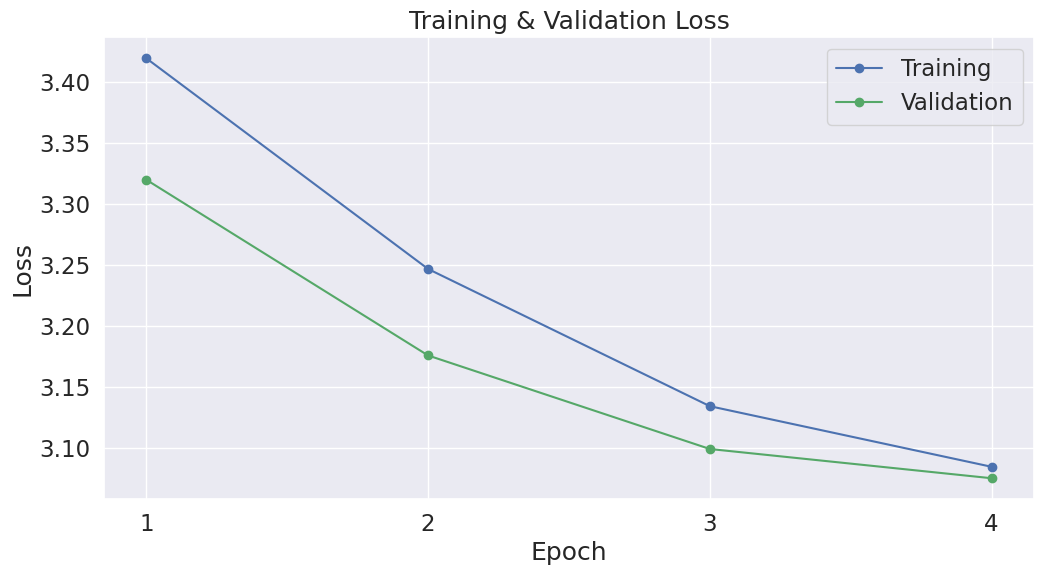

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Performance On Test Set


With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
# Prediction on test set

# print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()
model_wordembedding.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  word_embedding = [] # our word embedding input for the actual model
  b_labels = batch[2].type(torch.LongTensor).to(device) # labels (n = batch_size)

  # Tell pytorch not to bother with constructing the compute graph during
  # the forward pass, since this is only needed for backprop (training).
  with torch.no_grad():     
    ## extract emb from BERT need model.eval and with torch.no_grad()
    for i in range(len(batch[0])):
      b_input_ids = batch[0][i].view(1,len(batch[0][i])).to(device)
      b_input_mask = batch[1][i].view(1,len(batch[1][i])).to(device)
      
      # Run the text through BERT, and collect all of the hidden states produced
      outputs = model_wordembedding(input_ids = b_input_ids, attention_mask = b_input_mask)
      # BERT output (n_batch,maxlen,768)
      emb = outputs.last_hidden_state[0]
      word_embedding.append(emb)

  # stack list of sample tensor to batch tensor (batch_size, max_chunk*maxlen, 768)
  word_embedding = torch.stack(word_embedding)  

  out = model(word_embedding)

  # Move logits and labels to CPU
  logits = out.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

    DONE.


In [ ]:
flat_true_labels = np.concatenate(true_labels, axis=0)
flat_predictions = np.concatenate(predictions, axis=0)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
def f1_score_func(preds, labels, average='micro'):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average=average)

### Report

In [ ]:
print('Accuracy score =',flat_accuracy(flat_predictions, flat_true_labels))
print('F1 score micro =',f1_score_func(flat_predictions, flat_true_labels))
print('F1 score macro =',f1_score_func(flat_predictions, flat_true_labels, 'macro'))

Accuracy score = 0.0
F1 score micro = 0.22127659574468084
F1 score macro = 0.0198960173166222


/tmp/ipykernel_28/4083937354.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [ ]:
flat_predictions = flat_predictions.argmax(1).flatten()

In [ ]:
def flat_accuracy(preds, labels):
    # pred_flat = np.argmax(preds, axis=1).flatten()
    pred_flat = preds.flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
label_map = dict(zip(labelencoder.transform(labelencoder.classes_), labelencoder.classes_))

In [ ]:
pred_labels = [label_map[i] for i in flat_predictions]
test_labels = [label_map[i] for i in flat_true_labels]

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
category_list = list(label_map.values())
cm = confusion_matrix(pred_labels, test_labels)

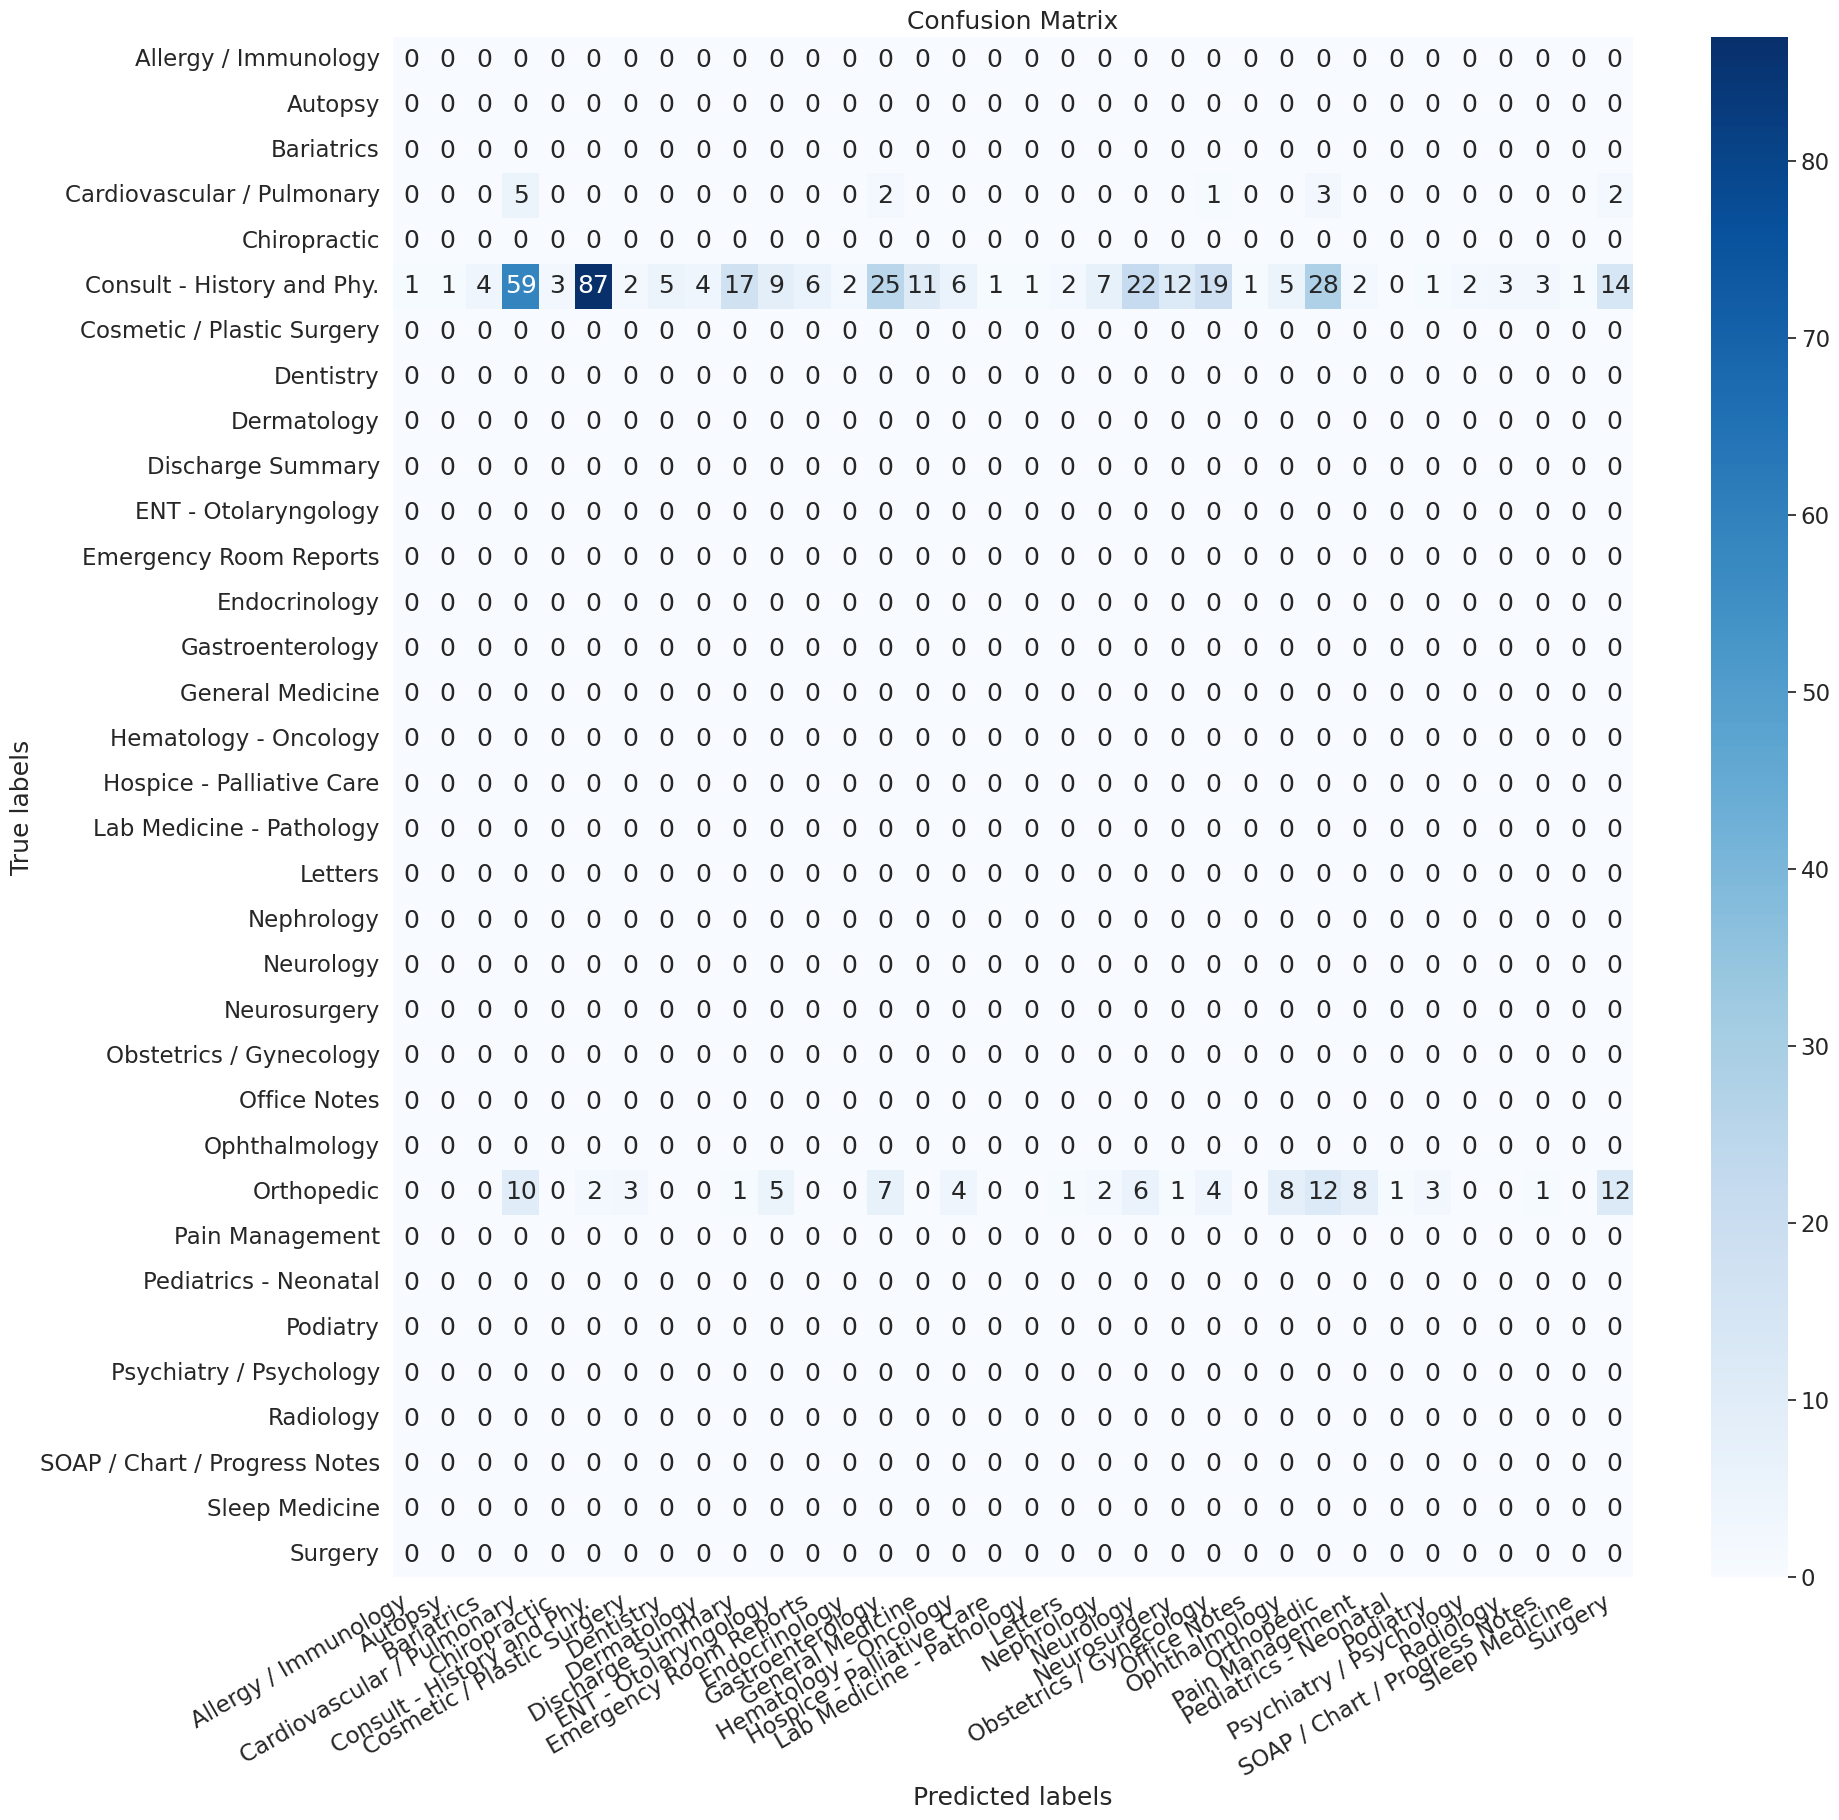

In [ ]:
fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Blues",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(category_list); ax.yaxis.set_ticklabels(category_list);
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

In [ ]:
print(classification_report(test_labels, pred_labels, labels = category_list))

                               precision    recall  f1-score   support

         Allergy / Immunology       0.00      0.00      0.00         1
                      Autopsy       0.00      0.00      0.00         1
                   Bariatrics       0.00      0.00      0.00         4
   Cardiovascular / Pulmonary       0.38      0.07      0.11        74
                 Chiropractic       0.00      0.00      0.00         3
   Consult - History and Phy.       0.24      0.98      0.38        89
   Cosmetic / Plastic Surgery       0.00      0.00      0.00         5
                    Dentistry       0.00      0.00      0.00         5
                  Dermatology       0.00      0.00      0.00         4
            Discharge Summary       0.00      0.00      0.00        18
         ENT - Otolaryngology       0.00      0.00      0.00        14
       Emergency Room Reports       0.00      0.00      0.00         6
                Endocrinology       0.00      0.00      0.00         2
     

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Saving & Loading BERT_LSTMmodel Model


In [ ]:
torch.save(model, "BERT_LSTMmodel.pth")

In [ ]:
# Load model
loadmodel = torch.load("BERT_LSTMmodel.pth")
loadmodel.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# Criticize the results from the baseline model based on theoretical and practical perspective with supporting literature
the result form BERT-LSTM model show poor performance because BERT was train on  wikipedia and internet text to get contexualize word embeding which not contain medical word that why feature extraction by BERT is not good representation literature suggest that you should you BERT model that pretrain on biomedical corpus and use seq classification instead of LSTM because paper show that model use Transformers as classification is better than other CNN, LSTM, biLSTM because of attension mechanism can solve problem of vanishing gradient

- A Survey of Transformer-based Biomedical Pretrained Language Models. /abs/2105.00827
- A comparative study on deep learning models for text classification of unstructured medical notes with various levels of class imbalance. https://doi.org/10.1186/s12874-022-01665-y
- Domain-Specific Language Model Pretraining for Biomedical Natural Language Processing. https://doi.org/10.1145/3458754

# Pubmed BERT fine tune model

## Pubmed BERT Tokenizer


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext', do_lower_case=True)
# bert-base-uncased
# microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext

Loading BERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was seen.  TMs were clear.,Neck:  Supple without a

find max sentence length

## BERT Fine-Tuning

## Train Classification Model

### BertForSequenceClassification

In [ ]:
from transformers import AutoModelForSequenceClassification, BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",#change model here # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = df['medical_specialty'].nunique(), # The number of output classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Ber

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

### Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 8 (GPU limitation)
* Learning rate: 5e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8
                )


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU
- Clear out the gradients in the previous pass. 
- Forward pass
- Backward pass (backpropagation)
- Update parameters with optimizer.step()
- Monitor progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU
- Forward pass
- Compute loss on our validation data
- Monotor progress


In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

We're ready to kick off the training!

In [ ]:
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        out           = model(b_input_ids,
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        total_train_loss += out[0].item()

        out[0].backward()

        # Clip the norm to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update weight
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            out            = model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += out[0].item()

        # Move logits and labels to CPU
        logits = out[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    
    torch.cuda.empty_cache()

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    177.    Elapsed: 0:00:17.
  Batch    80  of    177.    Elapsed: 0:00:34.
  Batch   120  of    177.    Elapsed: 0:00:51.
  Batch   160  of    177.    Elapsed: 0:01:08.

  Average training loss: 2.14
  Training epcoh took: 0:01:15

Running Validation...
  Accuracy: 0.66
  Validation Loss: 1.45
  Validation took: 0:00:08

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    177.    Elapsed: 0:00:17.
  Batch    80  of    177.    Elapsed: 0:00:34.
  Batch   120  of    177.    Elapsed: 0:00:51.
  Batch   160  of    177.    Elapsed: 0:01:09.

  Average training loss: 1.14
  Training epcoh took: 0:01:16

Running Validation...
  Accuracy: 0.76
  Validation Loss: 1.07
  Validation took: 0:00:08

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    177.    Elapsed: 0:00:17.
  Batch    80  of    177.    Elapsed: 0:00:34.
  Batch   120  of    177.    Elapsed: 0:00:51.
  Batch   160  of    177.    Elapsed: 0:01:09.



Let's view the summary of the training process.

In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,2.138774,1.453219,0.661017,0:01:15,0:00:08
2,1.141441,1.067205,0.756356,0:01:16,0:00:08
3,0.786190,0.973251,0.766949,0:01:16,0:00:08
4,0.550961,0.981270,0.773305,0:01:16,0:00:08


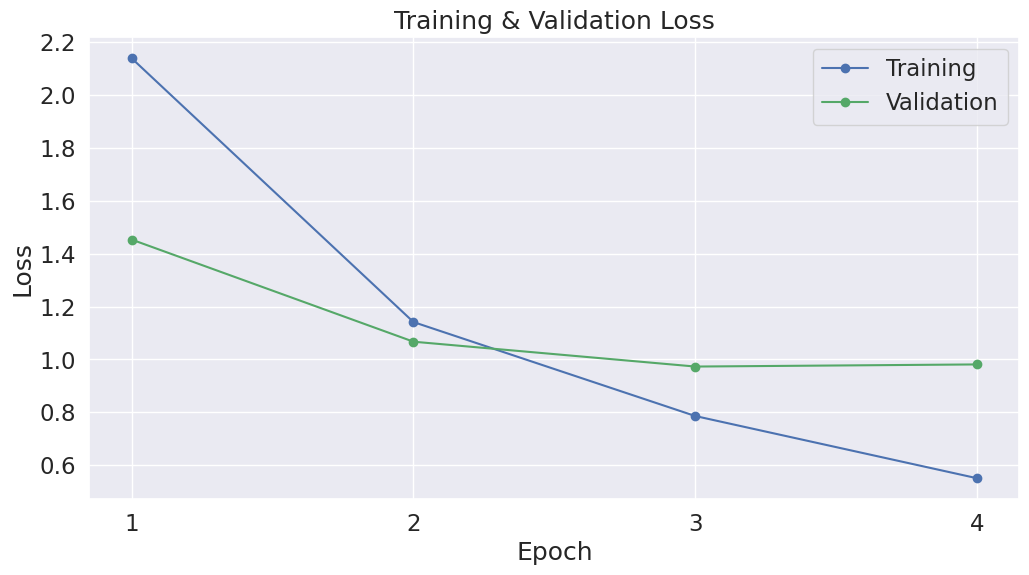

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Performance On Test Set


With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 472 test sentences...
    DONE.


In [ ]:
flat_true_labels = np.concatenate(true_labels, axis=0)
flat_predictions = np.concatenate(predictions, axis=0)

In [ ]:
flat_predictions.shape

(472, 34)

In [ ]:
flat_true_labels.shape

(472,)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
def f1_score_func(preds, labels, average='micro'):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average=average)

### Report

In [ ]:
print('Accuracy score =',flat_accuracy(flat_predictions, flat_true_labels))
print('F1 score micro =',f1_score_func(flat_predictions, flat_true_labels))
print('F1 score macro =',f1_score_func(flat_predictions, flat_true_labels, 'macro'))

Accuracy score = 0.7944915254237288
F1 score micro = 0.7944915254237288
F1 score macro = 0.5364019199168588


In [ ]:
flat_predictions = flat_predictions.argmax(1)

array([ 3,  3,  3,  3, 21,  8,  5,  5, 20,  5])

In [ ]:
pred_labels = [label_map[i] for i in flat_predictions]
test_labels = [label_map[i] for i in flat_true_labels]

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
category_list = list(label_map.values())
cm = confusion_matrix(pred_labels, test_labels)

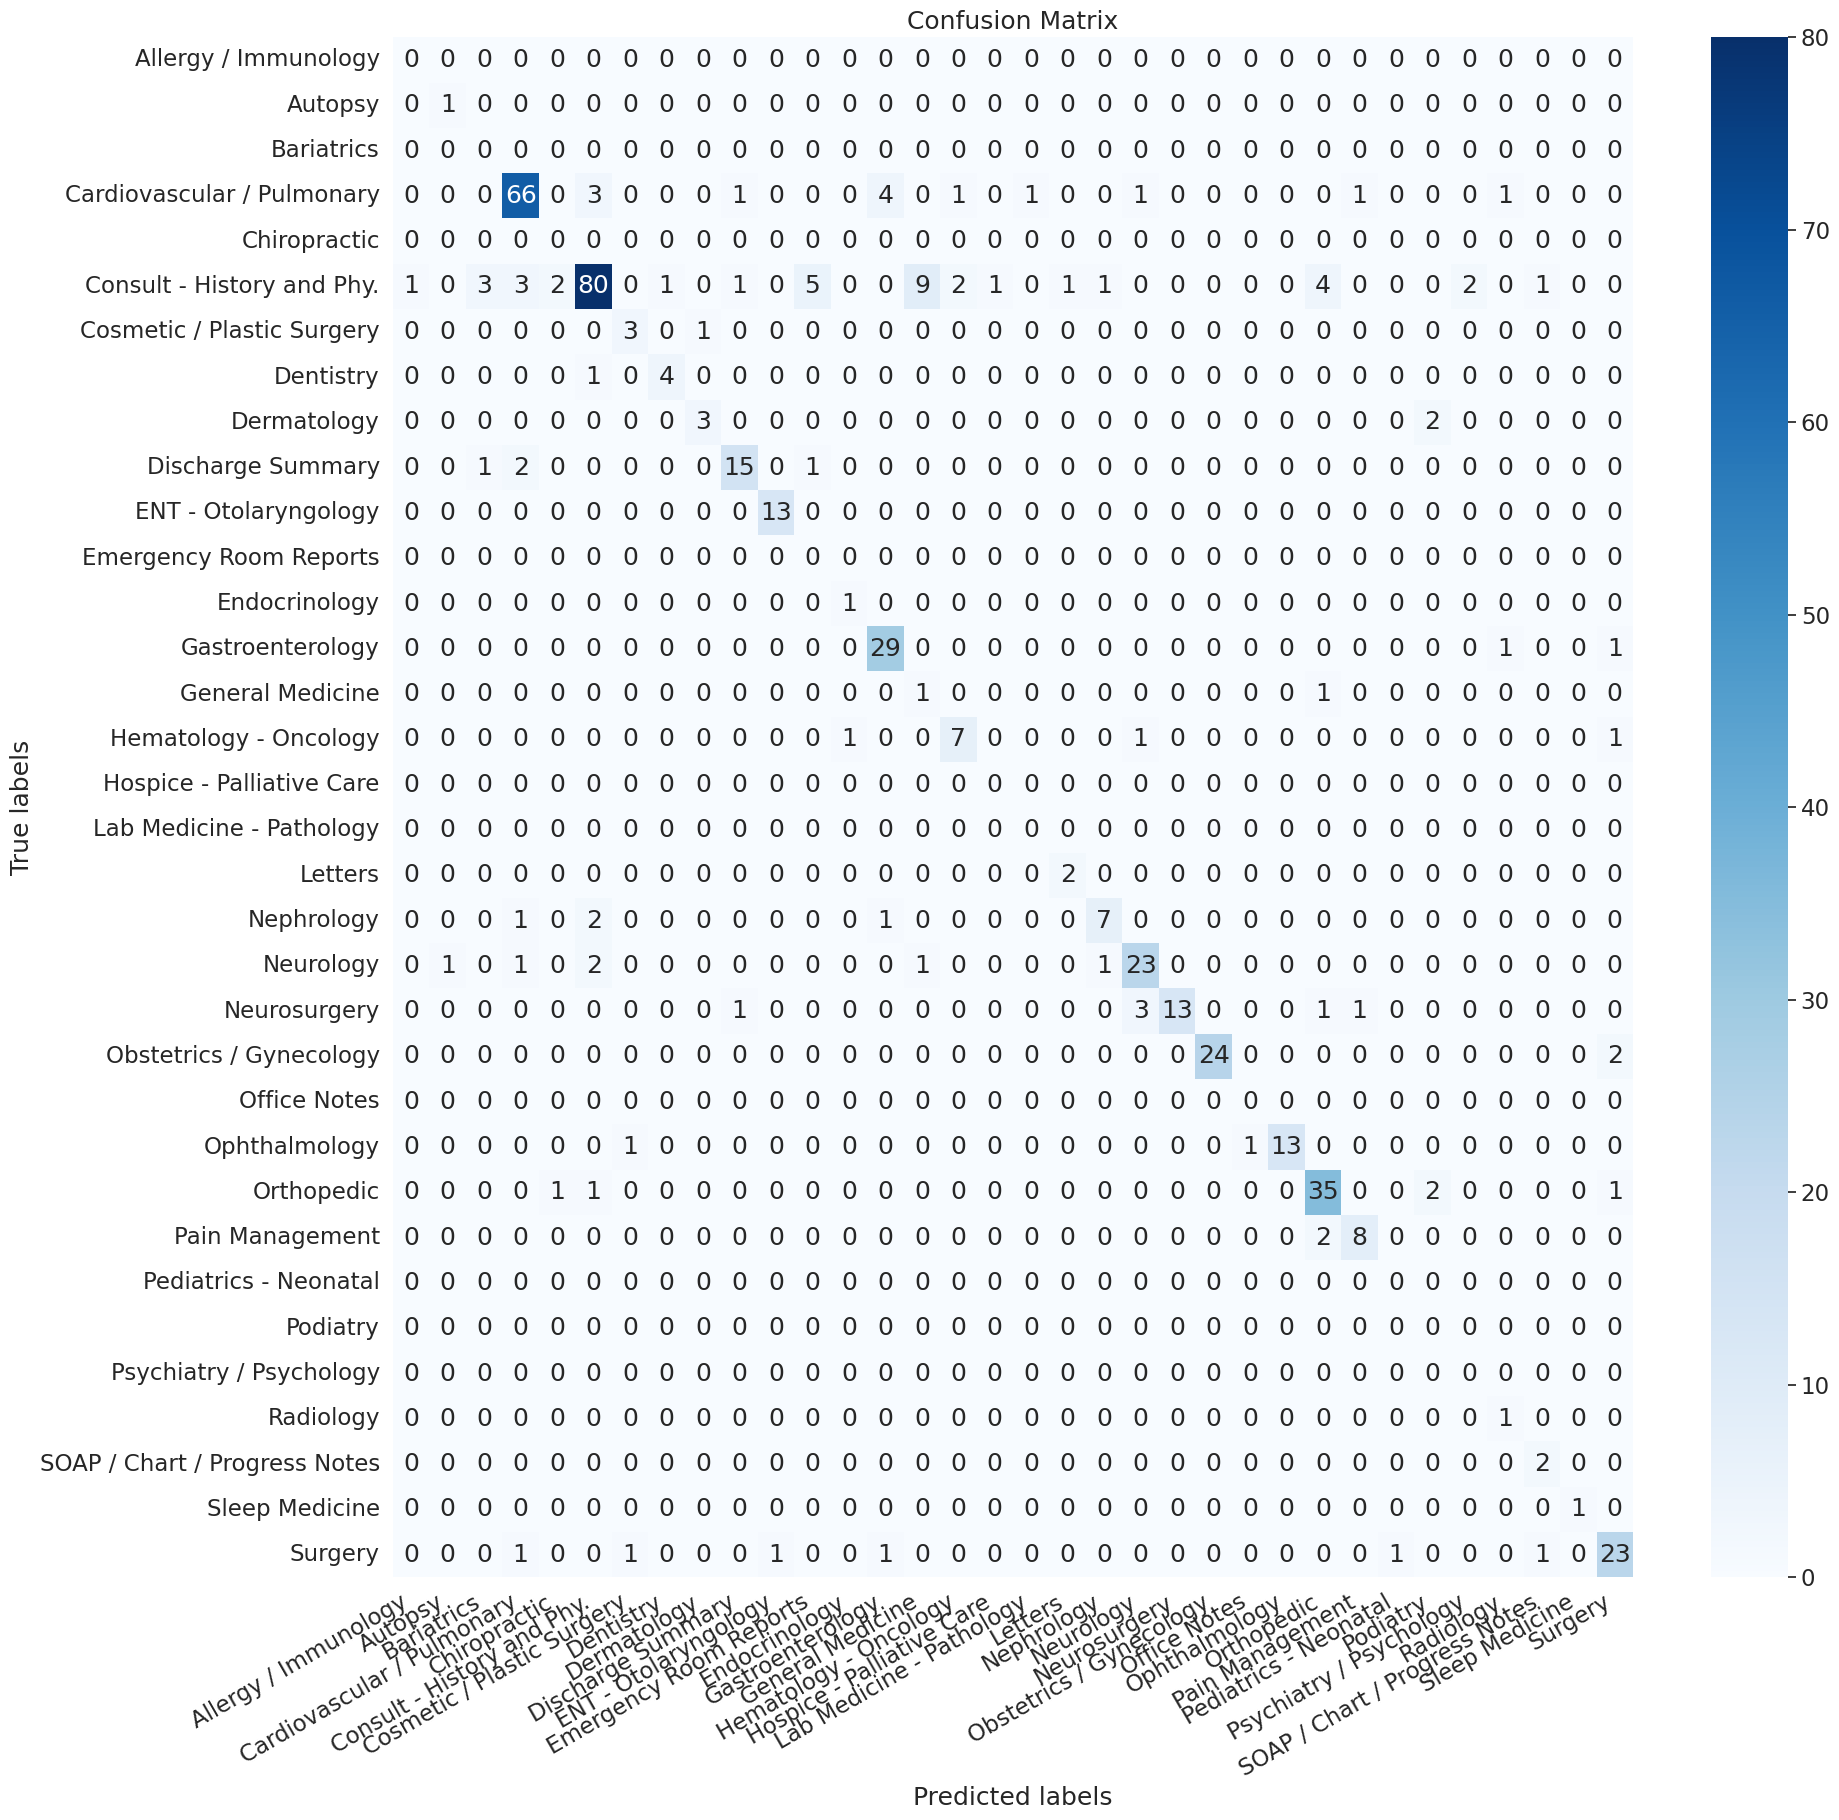

In [ ]:
fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Blues",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(category_list); ax.yaxis.set_ticklabels(category_list);
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

In [ ]:
print(classification_report(test_labels, pred_labels, labels = category_list))

                               precision    recall  f1-score   support

         Allergy / Immunology       0.00      0.00      0.00         1
                      Autopsy       1.00      0.50      0.67         2
                   Bariatrics       0.00      0.00      0.00         4
   Cardiovascular / Pulmonary       0.84      0.89      0.86        74
                 Chiropractic       0.00      0.00      0.00         3
   Consult - History and Phy.       0.68      0.90      0.78        89
   Cosmetic / Plastic Surgery       0.75      0.60      0.67         5
                    Dentistry       0.80      0.80      0.80         5
                  Dermatology       0.60      0.75      0.67         4
            Discharge Summary       0.79      0.83      0.81        18
         ENT - Otolaryngology       1.00      0.93      0.96        14
       Emergency Room Reports       0.00      0.00      0.00         6
                Endocrinology       1.00      0.50      0.67         2
     

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Saving & Loading PubmedBERTSeqClass Fine-Tuned Model


In [ ]:
torch.save(model, "PubmedBERTSeqClass.pth")

In [ ]:
# Load model
loadmodel = torch.load("PubmedBERTSeqClass.pth")
loadmodel.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# Conclusion

PubMed BERT fine tune is outperform normal BERT follow by LSTM show 
- BERT-LSTM
  - Accuracy score 0.0 (nearly 0% in testset) 
  - F1 score micro = 0.22127659574468084
  - F1 score macro = 0.0198960173166222  
- PubMed BERT
  - Accuracy score = 0.7944915254237288
  - F1 score micro = 0.7944915254237288
  - F1 score macro = 0.5364019199168588  
pubmed bert win all parameter and show good performance to predict accuracy and f1 micro score which weigth f1 by class


# Reference
- Transformer is out perform LSTM, CNN and other model  
Lu, H., Ehwerhemuepha, L. & Rakovski, C. A comparative study on deep learning models for text classification of unstructured medical notes with various levels of class imbalance. BMC Med Res Methodol 22, 181 (2022). https://doi.org/10.1186/s12874-022-01665-y

- Biomedical text classification is domain specific that can solve by BERT model that train on biomedical corpus
Yu Gu, Robert Tinn, Hao Cheng, Michael Lucas, Naoto Usuyama, Xiaodong Liu, Tristan Naumann, Jianfeng Gao, and Hoifung Poon. 2021. Domain-Specific Language Model Pretraining for Biomedical Natural Language Processing. ACM Trans. Comput. Healthcare 3, 1, Article 2 (January 2022), 23 pages. https://doi.org/10.1145/3458754
- Kalyan, K. S., Rajasekharan, A., & Sangeetha, S. (2021). AMMU : A Survey of Transformer-based Biomedical Pretrained Language Models. ArXiv. /abs/2105.00827